<a href="https://colab.research.google.com/github/berbir12/GAN-TheOriginalPaper/blob/main/TheGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! [ -e /content ] && pip install -Uqq fastbook
from fastbook import *
from fastai.vision.widgets import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.2 MB/s eta 0:00:00


In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.CIFAR)
dls = ImageDataLoaders.from_folder(path, valid='test', item_tfms=Resize(224))

xb, yb = dls.one_batch()
print(f"min pixel value: {xb.min()}, max pixel value: {xb.max()}")


min pixel value: TensorImage(0., device='cuda:0'), max pixel value: TensorImage(1., device='cuda:0')


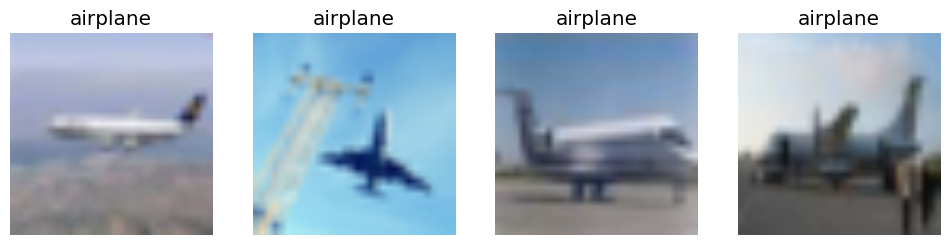

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
import os
os.makedirs("images", exist_ok=True)

# Define the arguments directly
n_epochs = 10
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 100
img_size = 28
channels = 1
sample_interval = 400

# Create a simple object to hold the arguments
class Args:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

opt = Args(
    n_epochs=n_epochs,
    batch_size=batch_size,
    lr=lr,
    b1=b1,
    b2=b2,
    n_cpu=n_cpu,
    latent_dim=latent_dim,
    img_size=img_size,
    channels=channels,
    sample_interval=sample_interval
)

print(opt.__dict__)

img_shape = (opt.channels, opt.img_size, opt.img_size)

{'n_epochs': 10, 'batch_size': 64, 'lr': 0.0002, 'b1': 0.5, 'b2': 0.999, 'n_cpu': 8, 'latent_dim': 100, 'img_size': 28, 'channels': 1, 'sample_interval': 400}


In [ ]:
import torch.nn as nn
from fastai.vision.all import *

class Maxout(nn.Module):
    def __init__(self, in_features, out_features, pieces):
        super().__init__()
        self.pieces = pieces
        self.lin = nn.Linear(in_features, out_features * pieces)

    def forward(self, x):
      shape = x.shape[:-1] + (self.pieces, -1)
      out = self.lin(x).view(*shape)
      out, _ = torch.max(out, dim=1)
      return out

class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_size =224, img_channels = 3):
        super().__init__()


        img_flat_size = img_size * img_size * img_channels

        self.main = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, img_flat_size),
            nn.Sigmoid()
        )

    def forward(self, input):

        output = self.main(input)

        return output.view(-1, 3, 224, 224)

class Discriminator(nn.Module):
    def __init__(self, img_size=224, img_channels=3):
        super().__init__()

        img_flat_size = img_size * img_size * img_channels
        pieces = 4
        self.net = nn.Sequential(
            Maxout(img_flat_size, 240, pieces),
            nn.Dropout(0.5),
            Maxout(240, 240, pieces),
            nn.Dropout(0.5),
            nn.Linear(240, 1),
            nn.Sigmoid()
        )



    def forward(self, input):
        return self.net(input.view(-1, 3 * 224 * 224))

In [ ]:
import math
from torchvision.utils import save_image
import torch.nn.functional as F
import torch
import torchvision.transforms as transform
from torch.autograd import Variable

cuda = True if torch.cuda.is_available() else False

adversarial_loss = torch.nn.BCELoss()


generator = Generator(img_size=224, img_channels=3)
discriminator = Discriminator(img_size=224, img_channels=3)

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()



# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))


Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor



for epoch in range(opt.n_epochs):
    for i, imgs_labels in enumerate(dls.train): # Modified line to unpack only images
        imgs = imgs_labels[0] # Unpack the images from the tuple
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)


        real_imgs = Variable(imgs.type(Tensor))



        optimizer_G.zero_grad()


        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)


        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()



        optimizer_D.zero_grad()


        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dls.train), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dls.train) + i
        if batches_done % opt.sample_interval == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

/tmp/ipython-input-1424844329.py:38: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)


Streaming output truncated to the last 5000 lines.
[Epoch 3/10] [Batch 467/781] [D loss: 0.334946] [G loss: 1.067663]
[Epoch 3/10] [Batch 468/781] [D loss: 0.364900] [G loss: 1.140031]
[Epoch 3/10] [Batch 469/781] [D loss: 0.364202] [G loss: 1.183787]
[Epoch 3/10] [Batch 470/781] [D loss: 0.314553] [G loss: 0.887236]
[Epoch 3/10] [Batch 471/781] [D loss: 0.383732] [G loss: 0.921988]
[Epoch 3/10] [Batch 472/781] [D loss: 0.384983] [G loss: 0.889749]
[Epoch 3/10] [Batch 473/781] [D loss: 0.424187] [G loss: 1.077465]
[Epoch 3/10] [Batch 474/781] [D loss: 0.383766] [G loss: 1.197692]
[Epoch 3/10] [Batch 475/781] [D loss: 0.388794] [G loss: 0.962554]
[Epoch 3/10] [Batch 476/781] [D loss: 0.404086] [G loss: 1.029958]
[Epoch 3/10] [Batch 477/781] [D loss: 0.400635] [G loss: 0.851104]
[Epoch 3/10] [Batch 478/781] [D loss: 0.442819] [G loss: 1.026962]
[Epoch 3/10] [Batch 479/781] [D loss: 0.378496] [G loss: 1.188432]
[Epoch 3/10] [Batch 480/781] [D loss: 0.557053] [G loss: 1.423457]
[Epoch 3/10